### Questions
- What are the different state/country datasets?
  - They are outputs of the simulation it seems...
  - TexasDataCenterSolarModeling.pdf is a saved mathematica notebook output specifically calculating the output NorthTexas2.csv
- What is the plot?
  - X: load capex (\\$/MW), Y: Power system capex (\\$/MWh-load over 10 years)
- I'd need to find the data used for the other cities...
  - It's all here: https://www.nrel.gov/grid/solar-power-data

In [1]:
import os

In [2]:
os.getcwd()

'/Users/alecchen/Documents/Code/solar-modeling'

In [3]:
import pandas as pd

In [71]:
import matplotlib.pyplot as plt

In [72]:
import datetime

In [202]:
import numpy as np

### Download

In [5]:
import os
import requests
import zipfile
import io

DATA_DIR = "data"

eastern_states = ['al', 'ak', 'ct', 'de', 'fl', 'ga', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nh', 'nj', 'nm-east', 'ny', 'nc', 'oh', 'ok', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx-east', 'vt', 'va', 'wv', 'wi']
western_states = ['az', 'ca', 'co', 'id', 'mt', 'nv', 'nm', 'or', 'sd', 'tx', 'ut', 'wa', 'wy']
all_states = eastern_states + western_states

def state_solar_zip_filename(state: str) -> str:
    return f"{state}-pv-2006.zip"

def state_download_url(state: str) -> str:
    return f"https://www.nrel.gov/docs/libraries/grid/{state_solar_zip_filename(state)}"

def state_data_dir(directory: str, state: str) -> str:
    return f"{directory}/{state}"

def download_state_solar_data(directory: str, state: str):
    print("Downloading solar data for", state)
    os.makedirs(directory, exist_ok=True)
    url = state_download_url(state)
    print("url:", url)
    extract_to = state_data_dir(directory, state)
    os.makedirs(extract_to, exist_ok=True)
    r = requests.get(url)
    try:
        z = zipfile.ZipFile(io.BytesIO(r.content))
    except Exception as e:
        print("Error when creating zip file from content:", e)
        return
    z.extractall(extract_to)
    files = os.listdir(extract_to)
    print(f"Downloaded: {len(os.listdir(extract_to))} total")

def unzip_state_solar_data(directory: str, state: str, zip_path: str):
    os.makedirs(directory, exist_ok=True)
    extract_to = state_data_dir(directory, state)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_to)

def check_downloaded(directory: str, state: str) -> bool:
    state_dir = state_data_dir(directory, state)
    return os.path.isdir(state_dir) and len(os.listdir()) > 0

def download_all_solar_data(directory: str, skip_existing: bool = True):
    for state in all_states:
        if check_downloaded(directory, state) and skip_existing:
            print(f"Already downloaded {state}, skipping...")
            continue
        download_state_solar_data(directory, state)

/Users/alecchen/Documents/Code/solar-modeling/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
from dataclasses import dataclass
from enum import Enum
import re

class DataType(str, Enum):
    ACTUAL = "Actual" # Real power output
    DA = "DA" # Day ahead forecast
    HA4 = "HA4" # 4 hour ahead forecast

    def __str__(self) -> str:
        return self.value

class PvType(str, Enum):
    UPV = "UPV" # Utility scale PV
    DPV = "DPV" # Distributed PV

    def __str__(self) -> str:
        return self.value

def solar_filename(data_type: DataType, latitude: float, longitude: float, weather_year: int, pv_type: PvType, capacity_mw: float, time_interval_min: int) -> str:
    return f"{data_type}_{round(latitude, 2)}_{round(longitude, 2)}_{weather_year}_{pv_type}_{int(capacity_mw) if capacity_mw.is_integer() else capacity_mw}MW_{time_interval_min}_Min.csv"

@dataclass(frozen=True)
class Dataset:
    data_type: DataType
    latitude: float
    longitude: float
    weather_year: int
    pv_type: PvType
    capacity_mw: float
    time_interval_min: int

    def filename(self) -> str:
        return solar_filename(**self.__dict__)

    @classmethod
    def from_filename(cls, filename: str) -> "Dataset":
        name = filename.removesuffix(".csv")
        parts = name.split("_")

        if len(parts) != 8:  # 8 because of "5_Min" being two parts
            raise ValueError(f"Unexpected filename format: {filename}")

        data_type_str, lat_str, lon_str, year_str, pv_type_str, capacity_str, interval_val, interval_label = parts

        if interval_label != "Min":
            raise ValueError(f"Expected 'Min' at the end of interval, got '{interval_label}'")

        capacity_mw = float(capacity_str[:-2]) # chop the MW
        interval_min = int(interval_val)

        return cls(
            data_type=DataType(data_type_str),
            latitude=float(lat_str),
            longitude=float(lon_str),
            weather_year=int(year_str),
            pv_type=PvType(pv_type_str),
            capacity_mw=capacity_mw,
            time_interval_min=interval_min
        )

example_filename = "Actual_33.45_-112.15_2006_DPV_103MW_5_Min.csv"
dataset = Dataset.from_filename(example_filename)
assert dataset.data_type == DataType.ACTUAL
assert dataset.latitude == 33.45
assert dataset.longitude == -112.15
assert dataset.weather_year == 2006
assert dataset.capacity_mw == 103
assert dataset.time_interval_min == 5
assert dataset.filename() == example_filename

example_float_cap_filename = "DA_43.05_-114.85_2006_UPV_0.2MW_60_Min.csv"
dataset_float_cap = Dataset.from_filename(example_float_cap_filename)
assert dataset_float_cap.capacity_mw == 0.2

### File exploration

In [7]:
# download_state_solar_data(DATA_DIR, "az")

In [8]:
download_all_solar_data(DATA_DIR)

Already downloaded al, skipping...
Already downloaded ak, skipping...
Already downloaded ct, skipping...
Already downloaded de, skipping...
Already downloaded fl, skipping...
Already downloaded ga, skipping...
Already downloaded il, skipping...
Already downloaded in, skipping...
Already downloaded ia, skipping...
Already downloaded ks, skipping...
Already downloaded ky, skipping...
Already downloaded la, skipping...
Already downloaded me, skipping...
Already downloaded md, skipping...
Already downloaded ma, skipping...
Already downloaded mi, skipping...
Already downloaded mn, skipping...
Already downloaded ms, skipping...
Already downloaded mo, skipping...
Already downloaded mt, skipping...
Already downloaded ne, skipping...
Already downloaded nh, skipping...
Already downloaded nj, skipping...
Already downloaded nm-east, skipping...
Already downloaded ny, skipping...
Already downloaded nc, skipping...
Already downloaded oh, skipping...
Already downloaded ok, skipping...
Already downloa

In [9]:
example_filename = "Actual_33.45_-112.15_2006_DPV_103MW_5_Min.csv"
dataset = Dataset.from_filename(example_filename)
STATE_COL = 'state'
FILENAME_COL = 'filename'
columns = [STATE_COL, FILENAME_COL] + list(dataset.__dict__.keys())

def create_state_files_df() -> pd.DataFrame:
    rows = []
    for state in all_states:
        assert check_downloaded(DATA_DIR, state)
        files = os.listdir(state_data_dir(DATA_DIR, state))
        state_rows = [{STATE_COL: state, FILENAME_COL: file, **Dataset.from_filename(file).__dict__} for file in files]
        rows += state_rows
    return pd.DataFrame(rows)

files_df = create_state_files_df()
empty_states = [state for state in all_states if state not in files_df[STATE_COL].unique()]
print("States with no files:", empty_states)
files_df.head()

States with no files: ['ak', 'oh', 'ok', 'pa', 'ri']


,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
0,al,DA_33.25_-87.45_2006_DPV_39MW_60_Min.csv,DA,33.25,-87.45,2006,DPV,39.0,60
1,al,HA4_34.15_-85.55_2006_UPV_70MW_60_Min.csv,HA4,34.15,-85.55,2006,UPV,70.0,60
2,al,Actual_32.55_-86.55_2006_UPV_40MW_5_Min.csv,Actual,32.55,-86.55,2006,UPV,40.0,5
3,al,Actual_30.75_-87.75_2006_DPV_36MW_5_Min.csv,Actual,30.75,-87.75,2006,DPV,36.0,5
4,al,Actual_34.55_-86.85_2006_DPV_37MW_5_Min.csv,Actual,34.55,-86.85,2006,DPV,37.0,5


In [10]:
len(files_df.loc[files_df["data_type"] == DataType.ACTUAL])

4690

In [11]:
files_df[STATE_COL].value_counts()

state
fl         1779
ca         1215
ga          996
sc          852
tn          816
va          663
mo          588
az          513
ky          477
al          411
ny          387
sd          378
ms          366
il          318
in          303
nj          300
la          279
co          264
mi          252
md          240
nv          231
wa          228
ut          198
tx          168
tx-east     168
ma          150
ks          138
ne          111
mn          108
nc          107
wi           96
ct           87
or           84
nm           81
nm-east      81
ia           75
wv           72
me           69
nh           60
de           48
id           42
mt           24
wy           21
vt           12
Name: count, dtype: int64

### Single state exploration

In [12]:
az_df = files_df.loc[files_df[STATE_COL] == "az"]
az_df.head()

,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
10610,az,HA4_32.55_-112.05_2006_UPV_100MW_60_Min.csv,HA4,32.55,-112.05,2006,UPV,100.0,60
10611,az,Actual_33.45_-112.15_2006_DPV_103MW_5_Min.csv,Actual,33.45,-112.15,2006,DPV,103.0,5
10612,az,HA4_33.85_-112.55_2006_UPV_28MW_60_Min.csv,HA4,33.85,-112.55,2006,UPV,28.0,60
10613,az,Actual_34.65_-114.15_2006_UPV_150MW_5_Min.csv,Actual,34.65,-114.15,2006,UPV,150.0,5
10614,az,Actual_32.85_-112.25_2006_UPV_50MW_5_Min.csv,Actual,32.85,-112.25,2006,UPV,50.0,5


In [13]:
len(az_df)

513

In [14]:
actual_df = az_df.loc[az_df["data_type"] == DataType.ACTUAL]
actual_df.head()

,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
10611,az,Actual_33.45_-112.15_2006_DPV_103MW_5_Min.csv,Actual,33.45,-112.15,2006,DPV,103.0,5
10613,az,Actual_34.65_-114.15_2006_UPV_150MW_5_Min.csv,Actual,34.65,-114.15,2006,UPV,150.0,5
10614,az,Actual_32.85_-112.25_2006_UPV_50MW_5_Min.csv,Actual,32.85,-112.25,2006,UPV,50.0,5
10619,az,Actual_36.05_-113.95_2006_UPV_100MW_5_Min.csv,Actual,36.05,-113.95,2006,UPV,100.0,5
10620,az,Actual_33.55_-112.85_2006_UPV_35MW_5_Min.csv,Actual,33.55,-112.85,2006,UPV,35.0,5


In [15]:
len(actual_df)

171

<Axes: >

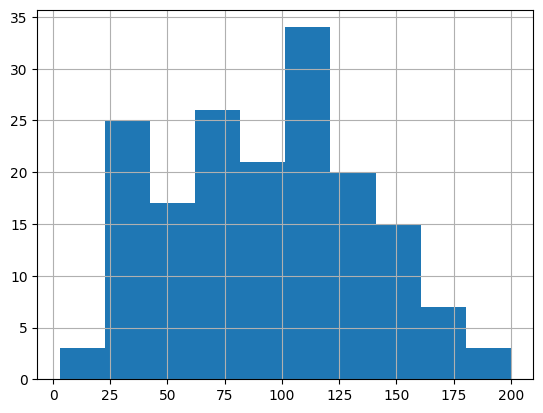

In [16]:
actual_df["capacity_mw"].hist()

In [17]:
actual_df.groupby(by=["weather_year"])["capacity_mw"].sum()

weather_year
2006    15807.0
Name: capacity_mw, dtype: float64

### Actual run some sort of simulation with this

In [18]:
actual_df["capacity_mw"]

np.float64(100.0)

In [19]:
actual_df.loc[actual_df["capacity_mw"] == actual_df["capacity_mw"].median()]

,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
10619,az,Actual_36.05_-113.95_2006_UPV_100MW_5_Min.csv,Actual,36.05,-113.95,2006,UPV,100.0,5
10628,az,Actual_34.85_-110.75_2006_UPV_100MW_5_Min.csv,Actual,34.85,-110.75,2006,UPV,100.0,5
10630,az,Actual_33.05_-111.75_2006_UPV_100MW_5_Min.csv,Actual,33.05,-111.75,2006,UPV,100.0,5
10634,az,Actual_33.95_-114.15_2006_UPV_100MW_5_Min.csv,Actual,33.95,-114.15,2006,UPV,100.0,5
10646,az,Actual_35.75_-114.65_2006_UPV_100MW_5_Min.csv,Actual,35.75,-114.65,2006,UPV,100.0,5
10663,az,Actual_34.15_-113.05_2006_UPV_100MW_5_Min.csv,Actual,34.15,-113.05,2006,UPV,100.0,5
10682,az,Actual_34.55_-114.25_2006_UPV_100MW_5_Min.csv,Actual,34.55,-114.25,2006,UPV,100.0,5
10692,az,Actual_33.65_-114.15_2006_UPV_100MW_5_Min.csv,Actual,33.65,-114.15,2006,UPV,100.0,5
10747,az,Actual_33.95_-113.85_2006_UPV_100MW_5_Min.csv,Actual,33.95,-113.85,2006,UPV,100.0,5
10762,az,Actual_35.75_-114.45_2006_UPV_100MW_5_Min.csv,Actual,35.75,-114.45,2006,UPV,100.0,5


In [34]:
import folium

US_STATE_CENTERS = {
    'ak': (64.0685, -152.2782),  # Alaska
    'al': (32.7794, -86.8287),   # Alabama
    'az': (34.2744, -111.2847),  # Arizona
    'ca': (36.7783, -119.4179),  # California
    'co': (39.0646, -105.3272),  # Colorado
    'ct': (41.5834, -72.7622),   # Connecticut
    'de': (39.1612, -75.5264),   # Delaware
    'fl': (27.7663, -81.6868),   # Florida
    'ga': (32.9866, -83.6487),   # Georgia
    'ia': (42.0046, -93.2140),   # Iowa
    'id': (44.2394, -114.5103),  # Idaho
    'il': (40.3363, -89.0022),   # Illinois
    'in': (39.8647, -86.2604),   # Indiana
    'ks': (38.5111, -96.8005),   # Kansas
    'ky': (37.6690, -84.6701),   # Kentucky
    'la': (31.1801, -91.8749),   # Louisiana
    'ma': (42.2373, -71.5314),   # Massachusetts
    'md': (39.0724, -76.7902),   # Maryland
    'me': (44.6074, -69.3977),   # Maine
    'mi': (43.3266, -84.5361),   # Michigan
    'mn': (45.7326, -93.9196),   # Minnesota
    'mo': (38.4623, -92.3020),   # Missouri
    'ms': (32.7673, -89.6812),   # Mississippi
    'mt': (47.2529, -110.0044),  # Montana
    'nc': (35.6411, -79.8431),   # North Carolina
    'ne': (41.1289, -98.2883),   # Nebraska
    'nh': (43.4108, -71.5653),   # New Hampshire
    'nj': (40.3140, -74.5089),   # New Jersey
    'nm': (34.8375, -106.2371),  # New Mexico
    'nv': (38.4199, -117.1219),  # Nevada
    'ny': (42.1657, -74.9481),   # New York
    'oh': (40.3736, -82.7755),   # Ohio
    'ok': (35.5376, -96.9247),   # Oklahoma
    'or': (44.5672, -122.1269),  # Oregon
    'pa': (40.5773, -77.2640),   # Pennsylvania
    'ri': (41.6772, -71.5101),   # Rhode Island
    'sc': (33.8191, -80.9066),   # South Carolina
    'sd': (44.2853, -99.4632),   # South Dakota
    'tn': (35.7449, -86.7489),   # Tennessee
    'tx': (31.1060, -97.6475),   # Texas
    'ut': (40.1135, -111.8535),  # Utah
    'va': (37.7680, -78.2057),   # Virginia
    'vt': (44.0407, -72.7093),   # Vermont
    'wa': (47.3917, -121.5708),  # Washington
    'wi': (44.2619, -89.6165),   # Wisconsin
    'wv': (38.4680, -80.9696),   # West Virginia
    'wy': (42.7475, -107.2085)   # Wyoming
}

def plot_with_folium(state: str):
    # Center map on Arizona
    center = US_STATE_CENTERS[state]
    
    # Create map
    m = folium.Map(location=center, zoom_start=7)
    
    # Add markers
    actual_state_df = files_df.loc[(files_df["data_type"] == DataType.ACTUAL) & (files_df[STATE_COL] == state)]
    coordinates = zip(actual_state_df["latitude"], actual_state_df["longitude"])
    for i, (lat, lon) in enumerate(coordinates):
        folium.Marker(
            [lat, lon],
            popup=f'Point {i+1}: ({lat}, {lon})',
            icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(m)
    
    # Save map
    m.save(f'{state}_map.html')
    print(f"Map saved as '{state}_map.html' - open in browser to view")
    return m

In [35]:
plot_with_folium("az")

Map saved as 'az_map.html' - open in browser to view


In [36]:
plot_with_folium("ca")

Map saved as 'ca_map.html' - open in browser to view


In [95]:
plot_with_folium("il")

Map saved as 'il_map.html' - open in browser to view


In [ ]:
# Things left to do
# - compute the solar utilization
# - find the minimum for that certain cost function...
# - run the sims...

### Solar utilization of a single plant

In [39]:
# Goal: plot the power generation over a day

In [172]:
actual_df = files_df.loc[(files_df["data_type"] == DataType.ACTUAL) & (files_df[STATE_COL] == "az")]
# actual_df = files_df.loc[(files_df["data_type"] == DataType.ACTUAL) & (files_df[STATE_COL] == "il")]
actual_df.head()

,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
10611,az,Actual_33.45_-112.15_2006_DPV_103MW_5_Min.csv,Actual,33.45,-112.15,2006,DPV,103.0,5
10613,az,Actual_34.65_-114.15_2006_UPV_150MW_5_Min.csv,Actual,34.65,-114.15,2006,UPV,150.0,5
10614,az,Actual_32.85_-112.25_2006_UPV_50MW_5_Min.csv,Actual,32.85,-112.25,2006,UPV,50.0,5
10619,az,Actual_36.05_-113.95_2006_UPV_100MW_5_Min.csv,Actual,36.05,-113.95,2006,UPV,100.0,5
10620,az,Actual_33.55_-112.85_2006_UPV_35MW_5_Min.csv,Actual,33.55,-112.85,2006,UPV,35.0,5


In [173]:
median_cap_df = actual_df.loc[actual_df["capacity_mw"] == actual_df["capacity_mw"].median()]
median_cap_df
# median_cap_df = actual_df.loc[(actual_df["latitude"] == 41.75) & (actual_df["longitude"] == -87.95)]
# median_cap_df

,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
10619,az,Actual_36.05_-113.95_2006_UPV_100MW_5_Min.csv,Actual,36.05,-113.95,2006,UPV,100.0,5
10628,az,Actual_34.85_-110.75_2006_UPV_100MW_5_Min.csv,Actual,34.85,-110.75,2006,UPV,100.0,5
10630,az,Actual_33.05_-111.75_2006_UPV_100MW_5_Min.csv,Actual,33.05,-111.75,2006,UPV,100.0,5
10634,az,Actual_33.95_-114.15_2006_UPV_100MW_5_Min.csv,Actual,33.95,-114.15,2006,UPV,100.0,5
10646,az,Actual_35.75_-114.65_2006_UPV_100MW_5_Min.csv,Actual,35.75,-114.65,2006,UPV,100.0,5
10663,az,Actual_34.15_-113.05_2006_UPV_100MW_5_Min.csv,Actual,34.15,-113.05,2006,UPV,100.0,5
10682,az,Actual_34.55_-114.25_2006_UPV_100MW_5_Min.csv,Actual,34.55,-114.25,2006,UPV,100.0,5
10692,az,Actual_33.65_-114.15_2006_UPV_100MW_5_Min.csv,Actual,33.65,-114.15,2006,UPV,100.0,5
10747,az,Actual_33.95_-113.85_2006_UPV_100MW_5_Min.csv,Actual,33.95,-113.85,2006,UPV,100.0,5
10762,az,Actual_35.75_-114.45_2006_UPV_100MW_5_Min.csv,Actual,35.75,-114.45,2006,UPV,100.0,5


In [174]:
# Just take the first median capacity plan
row = median_cap_df.iloc[0]
print(row[FILENAME_COL])
df = pd.read_csv(f"{DATA_DIR}/{row[STATE_COL]}/{row[FILENAME_COL]}")
df = df.rename(columns={"LocalTime": "local_time", "Power(MW)": "power_mw"})
df["local_time"] = pd.to_datetime(df["local_time"], format="%m/%d/%y %H:%M")
df.head()

Actual_36.05_-113.95_2006_UPV_100MW_5_Min.csv


,local_time,power_mw
0,2006-01-01 00:00:00,0.0
1,2006-01-01 00:05:00,0.0
2,2006-01-01 00:10:00,0.0
3,2006-01-01 00:15:00,0.0
4,2006-01-01 00:20:00,0.0


In [175]:
len(df)

105120

In [176]:
# 1 day = X 5min intervals = X rows
24 * 60 / 5

288.0

In [177]:
len(df) / 288

365.0

In [178]:
day_df = df.loc[df["local_time"].dt.date == datetime.date(2006, 1, 1)]
len(day_df)

288

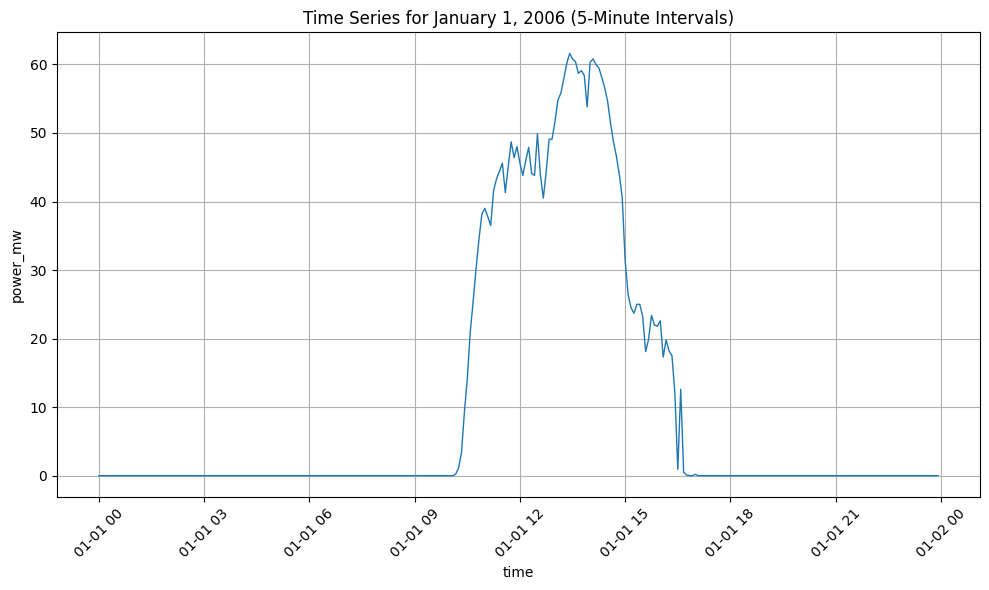

In [179]:
import matplotlib.pyplot as plt

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(day_df['local_time'], day_df['power_mw'], linestyle='-', linewidth=1)
plt.title('Time Series for January 1, 2006 (5-Minute Intervals)')
plt.xlabel('time')
plt.ylabel('power_mw')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [180]:
df['date'] = df['local_time'].dt.date
df['time'] = df['local_time'].dt.strftime('%H:%M')
df.head()

,local_time,power_mw,date,time
0,2006-01-01 00:00:00,0.0,2006-01-01,00:00
1,2006-01-01 00:05:00,0.0,2006-01-01,00:05
2,2006-01-01 00:10:00,0.0,2006-01-01,00:10
3,2006-01-01 00:15:00,0.0,2006-01-01,00:15
4,2006-01-01 00:20:00,0.0,2006-01-01,00:20


In [181]:
df_pivot = df.pivot(index='time', columns='date', values='power_mw')
df_pivot

date,2006-01-01,2006-01-02,2006-01-03,2006-01-04,2006-01-05,2006-01-06,2006-01-07,2006-01-08,2006-01-09,2006-01-10,...,2006-12-22,2006-12-23,2006-12-24,2006-12-25,2006-12-26,2006-12-27,2006-12-28,2006-12-29,2006-12-30,2006-12-31
time,,,,,,,,,,,,,,,,,,,,,
00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23:35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23:40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23:45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


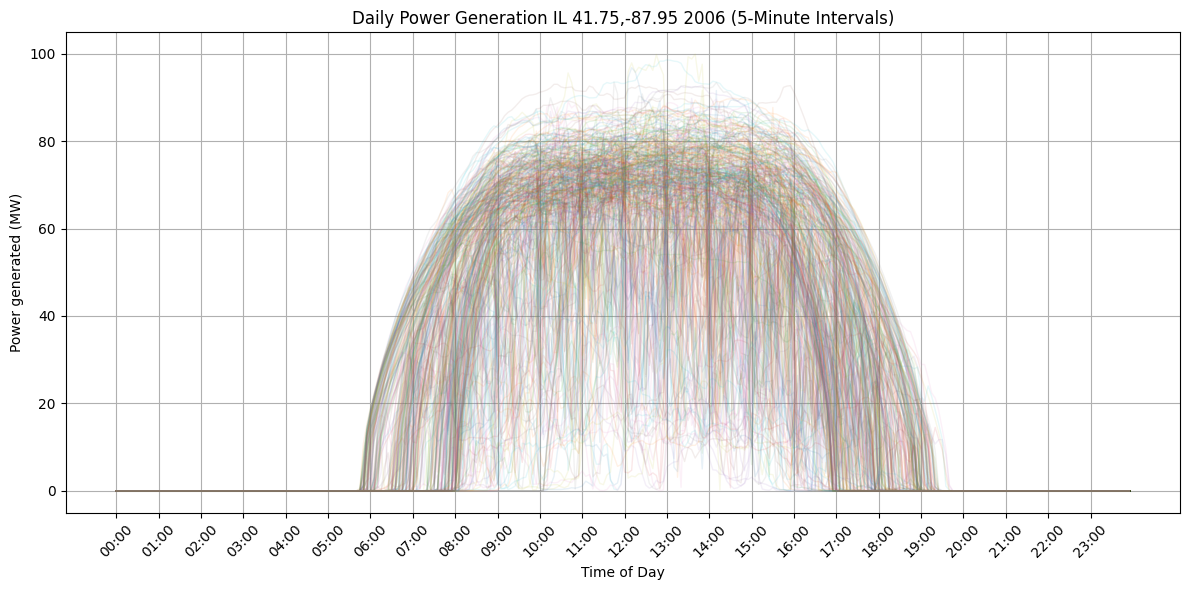

In [182]:
plt.figure(figsize=(12, 6))
for column in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[column], alpha=0.1, linewidth=1)

plt.title('Daily Power Generation IL 41.75,-87.95 2006 (5-Minute Intervals)')
plt.xlabel('Time of Day')
plt.ylabel('Power generated (MW)')
plt.grid(True)
plt.xticks(df_pivot.index[::12], rotation=45)  # Show every 12th time (hourly)
plt.tight_layout()
plt.show()

In [183]:
# Mean utilization
df.head()

,local_time,power_mw,date,time
0,2006-01-01 00:00:00,0.0,2006-01-01,00:00
1,2006-01-01 00:05:00,0.0,2006-01-01,00:05
2,2006-01-01 00:10:00,0.0,2006-01-01,00:10
3,2006-01-01 00:15:00,0.0,2006-01-01,00:15
4,2006-01-01 00:20:00,0.0,2006-01-01,00:20


In [184]:
mean_util = df["power_mw"].mean() / row["capacity_mw"] * 100
print(f"{mean_util:.2f}%")

25.88%


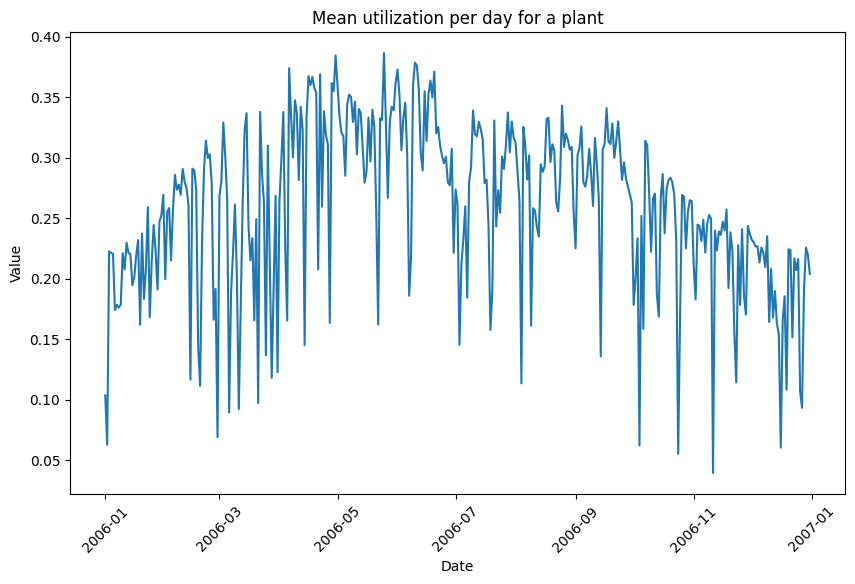

In [201]:
day_df = (df.groupby(by=["date"])["power_mw"].mean() / row["capacity_mw"]).reset_index()

plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(day_df['date'], day_df['power_mw'])  # Line plot with markers
plt.title('Mean utilization per day for a plant')  # Add title
plt.xlabel('Date')  # Label x-axis
plt.ylabel('Value')  # Label y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()  # Display the plot

### Simulating capex

Some questions to keep in mind
- Are we accounting for battery degradation?
- Where did the 200,000/MW assumption come from? How does it hold up to reality?

In [301]:
def uptime_with_battery(caps: np.array, loads: np.array, sol: np.array) -> pd.DataFrame:
    """
    Simulates battery storage system to compute uptime and utilization.

    An assumption here is that load is constant, when in reality it fluctuates.
    It would be really cool to get a load data set to fill in the variability
    across each part of the day/year.

    Can also simulate as no battery system if caps are all zero.
    
    Parameters:
    caps (list or array): List of battery capacities (kWh).
    loads (list or array): List of load demands (kW).
    sol (list or array): Solar generation (kW) over time steps.

    Important thing here is that all parameters are in the same kW vs mW unit.
    
    Returns:
    numpy.ndarray: Array with shape (4, len(caps), len(loads)) containing:
        - Battery capacities
        - Load demands
        - Uptime (fraction of time battery is non-empty)
        - Utilization (fraction of load met)
    """
    # Initialize arrays
    n_steps = len(sol)
    n_caps = len(caps)
    n_loads = len(loads)
    time_step = 8760 / n_steps  # Time step in hours since capacity is in xWh
    
    # 3D array for battery state: [time steps, capacities, loads]
    batt = np.full((n_steps, n_caps, n_loads), caps[:, np.newaxis])
    
    # 3D array for utilization, initialized to zeros
    util = np.zeros_like(batt)
    
    # 2D matrices for loads and capacities
    loadsmat = np.tile(loads, (n_caps, 1))  # [caps, loads]
    capsmat = np.tile(caps[:, np.newaxis], (1, n_loads))  # [caps, loads]
    
    # Main loop over time steps
    for i in range(n_steps - 1):
        # Solar discretization: 1 if solar >= load, 0 otherwise
        # sundisc = 0.5 + 0.5 * np.sign(sol[i] - loadsmat)
        sundisc = (sol[i] >= loadsmat).astype(int)
        
        # Battery discharge discretization: 1 if battery can cover shortfall
        # Make sure that we don't accidentally add to battery if solar exceeds load
        # battdisc = 0.5 + 0.5 * np.sign(batt[i] - time_step * (loadsmat - sol[i]))
        battdisc = (batt[i] >= time_step * np.maximum(loadsmat - sol[i], 0.)).astype(int)
        
        # Utilization update
        util[i] = (sundisc + 
                   (1 - sundisc) * battdisc + 
                   (1 - sundisc) * (1 - battdisc) * 
                   (sol[i] / loadsmat + batt[i] / (time_step * loadsmat)))
        
        # Battery state update
        batt[i + 1] = (sundisc * (batt[i] + time_step * (sol[i] - loadsmat)) + 
                       (1 - sundisc) * battdisc * (batt[i] - time_step * (loadsmat - sol[i])) + 
                       (1 - sundisc) * (1 - battdisc) * 0.) # 0 case here just to explicitly show else clause

        # Apply capacity constraint
        # NOTE: important difference between this and reference,
        # we need to compute capdisc on the next battery state not the current.
        # This fixes a bug where we get "uptime" even when we pass in
        # a battery with capacity 0.
        batt[i + 1] = np.minimum(batt[i + 1], capsmat)

    # Compute uptime (fraction of time battery is non-empty)
    uptime = np.mean(np.sign(batt), axis=0)
    
    # Compute utilization (fraction of load met)
    utilization = np.mean(util, axis=0)
    
    # Create DataFrame
    # Flatten capsmat, loadsmat, uptime, and utilization for DataFrame
    caps_flat = capsmat.flatten()
    loads_flat = loadsmat.flatten()
    uptime_flat = uptime.flatten()
    utilization_flat = utilization.flatten()
    
    # Construct DataFrame
    df = pd.DataFrame({
        'capacity': caps_flat,
        'load': loads_flat,
        'uptime': uptime_flat,
        'utilization': utilization_flat
    })
    
    return df

no_battery_example = uptime_with_battery(np.array([0]), np.array([10]), np.array([20, 20]))
assert no_battery_example.iloc[0]["uptime"] == 0.

In [302]:
%%time
caps = np.array([0, 10, 20, 50])
loads = np.array([5, 10, 20])
# sol = np.random.rand(8760) * 15  # 8760 hours of random solar data
sol = df["power_mw"]
result = uptime_with_battery(caps, loads, sol)
result

CPU times: user 2.92 s, sys: 13.7 ms, total: 2.94 s
Wall time: 2.94 s


,capacity,load,uptime,utilization
0,0,5,0.000000,0.450447
1,0,10,0.000000,0.444340
2,0,20,0.000000,0.415459
3,10,5,0.478130,0.488642
4,10,10,0.469454,0.483647
5,10,20,0.428577,0.444720
6,20,5,0.513337,0.523659
7,20,10,0.504994,0.518645
8,20,20,0.448525,0.463651
9,50,5,0.617561,0.627844
